### Run scrublet on the Sanger total cells post `cellbender`

- Carlos Talavera-López PhD
- Wellcome Sanger Institite - 191205


### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

/opt/conda/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

Running Scanpy 1.4.3 on 2019-12-05 11:55.


### Read datasets

In [3]:
heart_nuclei = anndata.read_h5ad('/home/jovyan/experiments/0-generate_anndata_objects/sanger_heart_cDNA_CellBender_RAW_ctl191205.h5ad')
heart_nuclei.var_names_make_unique()
heart_nuclei.shape

(221220, 33538)

### Remove empty droplets

In [4]:
sample_object = heart_nuclei.copy()
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1)
sample_object.obs['n_counts'].describe()

count    221220.000000
mean       1777.857666
std        3404.960449
min           0.000000
25%         469.000000
50%         880.000000
75%        1707.000000
max      165938.000000
Name: n_counts, dtype: float64

In [5]:
sample_object.shape

(221220, 33538)

### Remove cells or Nuclei with less than 200 genes

In [6]:
sc.pp.filter_cells(data = sample_object, min_genes = 200)
sample_object.shape

filtered out 145648 cells that have less than 200 genes expressed


(75572, 33538)

### Compute QC stats

In [7]:
sample_object.shape

(75572, 33538)

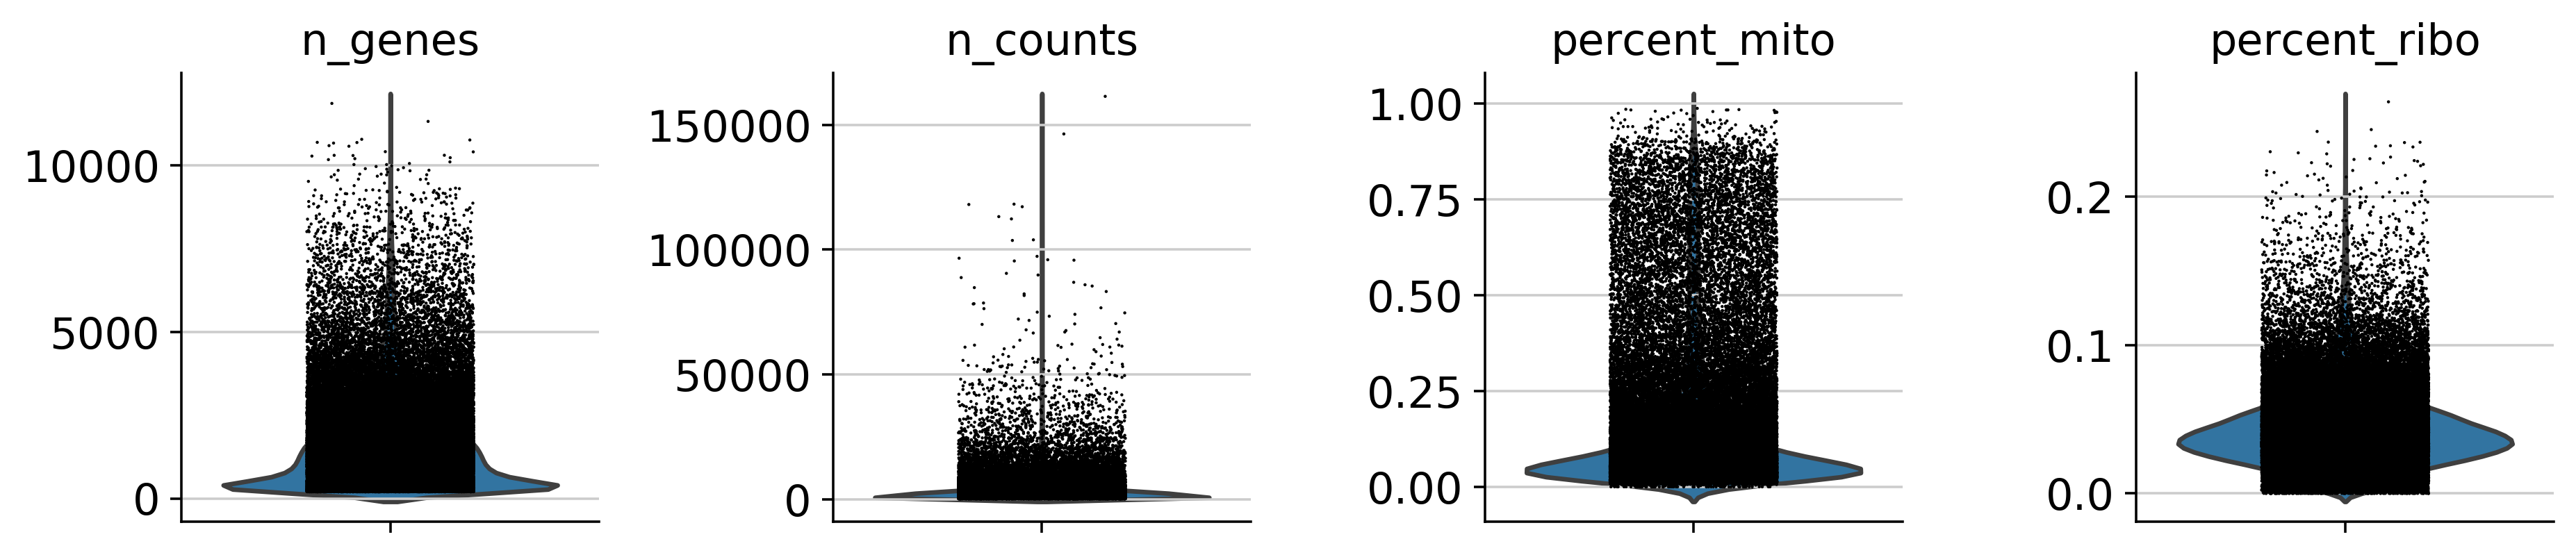

In [8]:
mito_cells = sample_object.var_names.str.startswith('MT-')
ribo_cells = sample_object.var_names.str.startswith('RPS','RPL')
sample_object.obs['percent_mito'] = np.sum(sample_object[:, mito_cells].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sample_object.obs['percent_ribo'] = np.sum(sample_object[:, ribo_cells].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sc.pl.violin(sample_object, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'], jitter = 0.2, multi_panel = True)

### Remove cells/nuclei exceeding the ribo/mito threshold 

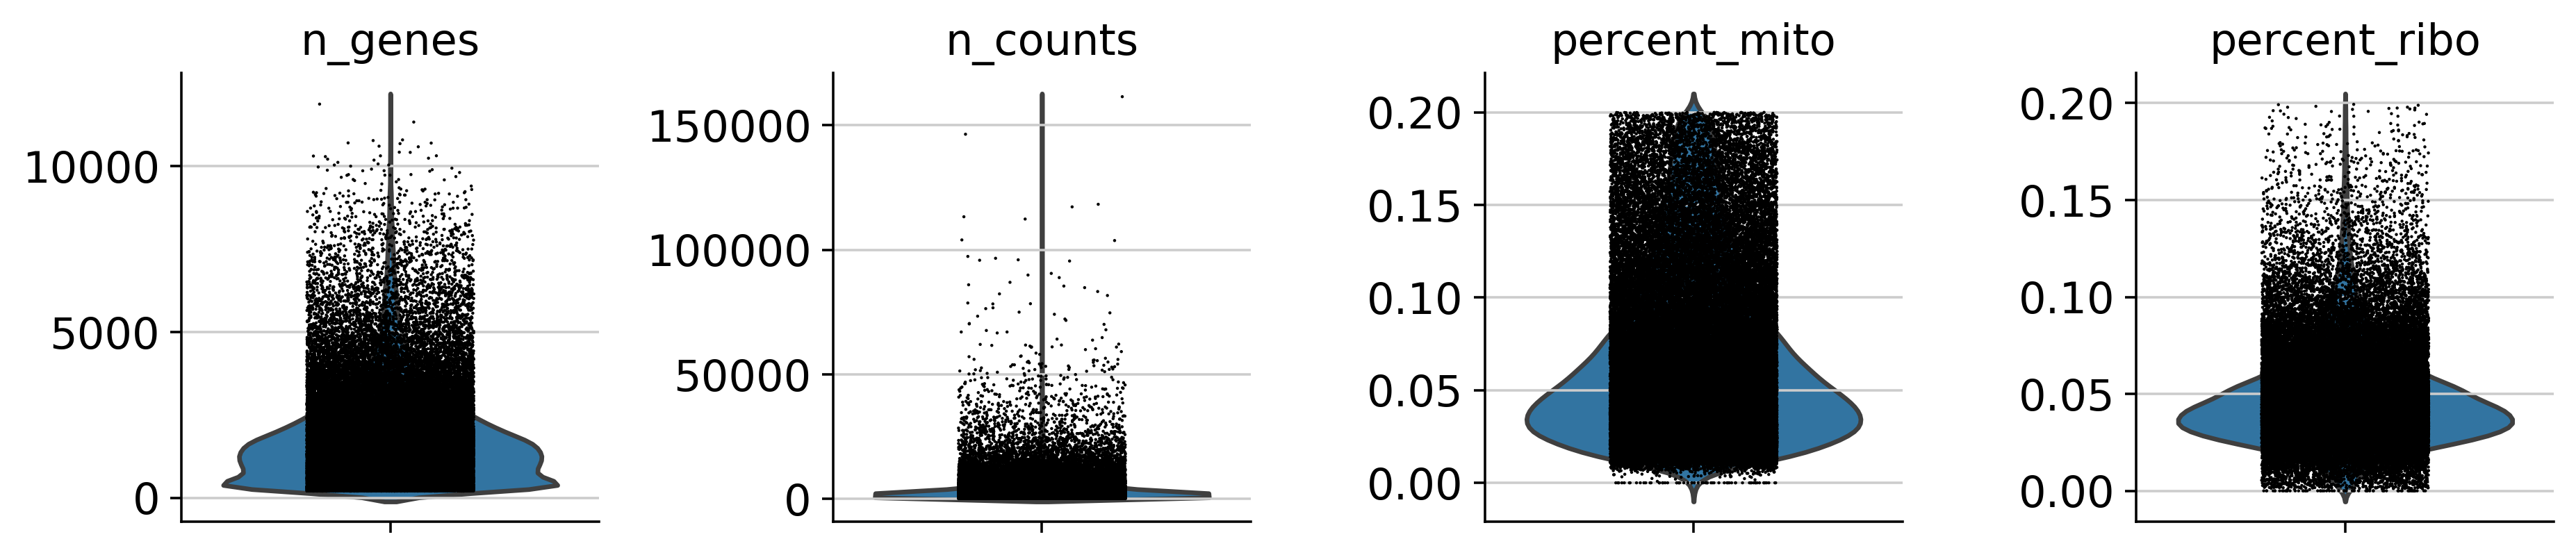

In [9]:
sample_object = sample_object[sample_object.obs['percent_mito'] < 0.2, :]
sample_object = sample_object[sample_object.obs['percent_ribo'] < 0.2, :]
sc.pl.violin(sample_object, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],jitter = 0.2, multi_panel = True)

In [10]:
sample_object.shape

(60584, 33538)

### Create a working copy of the data and process it

In [11]:
sample_object_backup = sample_object.copy()
sc.pp.normalize_per_cell(sample_object, counts_per_cell_after = 1e4)
sc.pp.log1p(sample_object)
sc.pp.highly_variable_genes(sample_object, n_top_genes = 1000)
heart_hvg = sample_object[:, sample_object.var['highly_variable']]
sc.pp.scale(heart_hvg, max_value = 10)
heart_hvg.shape

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


(60584, 1000)

### Compute PCA

In [12]:
sc.tl.pca(heart_hvg, svd_solver = 'arpack', random_state = 1712)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:08.60)


### Identify doublets via scrublets using an AnnData-friendly version

In [13]:
from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix
import numpy as np


def woublet(
        adata,
        sim_doublet_ratio = 2,
        n_neighbors = 30,
        expected_doublet_rate = 0.1,
        total_counts_key = 'n_counts',
        copy = False):
    
    adata = adata.copy() if copy else adata

    if 'X_pca' not in adata.obsm_keys():
        raise ValueError(
            'Did not find \'X_pca\'. Run `sc.pp.pca` first.')

    if total_counts_key in adata.obs:
        total_counts = np.array(adata.obs[total_counts_key])
    else:
        total_counts = np.ones(adata.X.shape[0])

    # Simulate doublets by averaging PC coordinates of random cell pairs
    logg.info('Simulating doublets')
    PCdat, doub_labels, parent_ix = simulate_doublets_from_pca(adata.obsm['X_pca'], 
        total_counts = total_counts, 
        sim_doublet_ratio = sim_doublet_ratio)


    adata_doub = AnnData(csc_matrix((PCdat.shape[0], 1)))
    adata_doub.obsm['X_pca'] = PCdat

    # Calculate doublet scores using k-nearest-neighbor classifier
    logg.info('Running KNN classifier')
    adata.obs['doublet_score'], adata.uns['sim_doublet_score'] = calculate_doublet_scores(
        adata_doub, 
        doub_labels, 
        n_neighbors = n_neighbors, 
        expected_doublet_rate = expected_doublet_rate)

    adata.obs['doublet_score']

    return adata if copy else None



#========================================================================================#

def simulate_doublets_from_pca(PCdat, total_counts=[], sim_doublet_ratio=1):
    '''
    Simulate doublets by averaging PCA coordinates of random cell pairs.
    Average is weighted by total counts of each parent cell, if provided.

    Returns:
    PCdoub (matrix of size (num_cells+num_sim_doubs, num_pcs)): PCA matrix with the simulated doublet PCA coordinates appended to the original data matrix PCdat.
    doub_labels (array of size (num_cells+num_sim_doubs)): 0 if observed cell, 1 if simulated doublet
    pair_ix (matrix of size(num_sim_doubs, 2)): each row gives the indices of the parent cells used to generate the simulated doublet
    '''

    n_obs = PCdat.shape[0]
    n_doub = int(n_obs * sim_doublet_ratio)

    if len(total_counts) == 0:
        total_counts = np.ones(n_obs)

    pair_ix = np.random.randint(0, n_obs, size = (n_doub, 2))

    pair_tots = np.hstack((total_counts[pair_ix[:, 0]][:,None], total_counts[pair_ix[:, 1]][:,None]))
    pair_tots = np.array(pair_tots, dtype=float)
    pair_fracs = pair_tots / np.sum(pair_tots, axis=1)[:,None]

    PCdoub = PCdat[pair_ix[:, 0],:] * pair_fracs[:, 0][:,None] + PCdat[pair_ix[:, 1],:] * pair_fracs[:, 1][:,None]

    PCdoub = np.vstack((PCdat, PCdoub))
    doub_labels = np.concatenate((np.zeros(n_obs), np.ones(n_doub)))

    return PCdoub, doub_labels, pair_ix

#========================================================================================#

def calculate_doublet_scores(adata, doub_labels, n_neighbors=30, expected_doublet_rate = 1.0):
    n_obs = sum(doub_labels == 0)
    n_sim = sum(doub_labels == 1)

    # Adjust k (number of nearest neighbors) based on the ratio of simulated to observed cells
    k_adj = int(round(n_neighbors * (1+n_sim/float(n_obs))))

    # Find k_adj nearest neighbors
    neighbors(adata, n_neighbors = k_adj, use_rep = 'X_pca')

    # Calculate doublet score based on ratio of simulated cell neighbors vs. observed cell neighbors
    matrix = adata.uns['neighbors']['distances']
    n_sim_neigh = (matrix[:,doub_labels == 1]>0).sum(1).A.squeeze()
    n_obs_neigh = (matrix[:,doub_labels == 0]>0).sum(1).A.squeeze()
    
    doub_score = n_sim_neigh / (n_sim_neigh + n_obs_neigh * n_sim / float(n_obs) / expected_doublet_rate)
    doub_score_obs = doub_score[doub_labels == 0]

    # return doublet scores for observed cells and simulated cells
    return doub_score[doub_labels == 0], doub_score[doub_labels == 1]

### Run scrublet on each sample

In [14]:
holder = np.zeros((heart_hvg.shape[0],))
for smp in np.unique(heart_hvg.obs['sample']):
#    if smp == []:
    if any( [smp == 'HCAHeart7728604', smp == 'HCAHeart7728609']):
        continue
    adata_smp = heart_hvg[heart_hvg.obs['sample'] == smp]
    sc.tl.pca(adata_smp, svd_solver = 'arpack', random_state = 1786)
    woublet(adata_smp)
    holder[heart_hvg.obs['sample'] == smp] = adata_smp.obs['doublet_score']
heart_hvg.obs['doublet_score'] = holder

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.26)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../opt/conda/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/opt/conda/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/numba/compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path t

    finished (0:00:02.58) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.93)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:00.36) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.12)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:01.03) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.65)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:00.41) --> added t

/opt/conda/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /opt/conda/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7f4d6a492950>)))
[2] Du

    finished (0:00:13.06) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02.08)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:01.98) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.51)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:00.44) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.56)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:03.45) --> added t

/opt/conda/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:25.91) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05.45)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:42.42) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.42)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:01.56) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03.65)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:02.12) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02.55)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:16.01) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04.94)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:34.70) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02.12)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:00.49) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.17)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:00.20) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.46)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:00.40) --> added t

/opt/conda/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:24.04) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05.82)
Simulating doublets
Running KNN classifier
computing neighbors
    finished (0:00:01.55) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03.47)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:19.16) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


### Visualise scrublet scores

In [15]:
sc.tl.pca(heart_hvg, svd_solver = 'arpack', random_state = 1712)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:14.54)


In [16]:
sc.pp.neighbors(heart_hvg, random_state = 1786)
sc.tl.umap(heart_hvg, min_dist = 0.2, spread = 1, random_state = 1712)

computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /opt/conda/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7f4d6a492950>)))
[2] Du

    finished (0:00:23.96) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:02:05.82) --> added
    'X_umap', UMAP coordinates (adata.obsm)


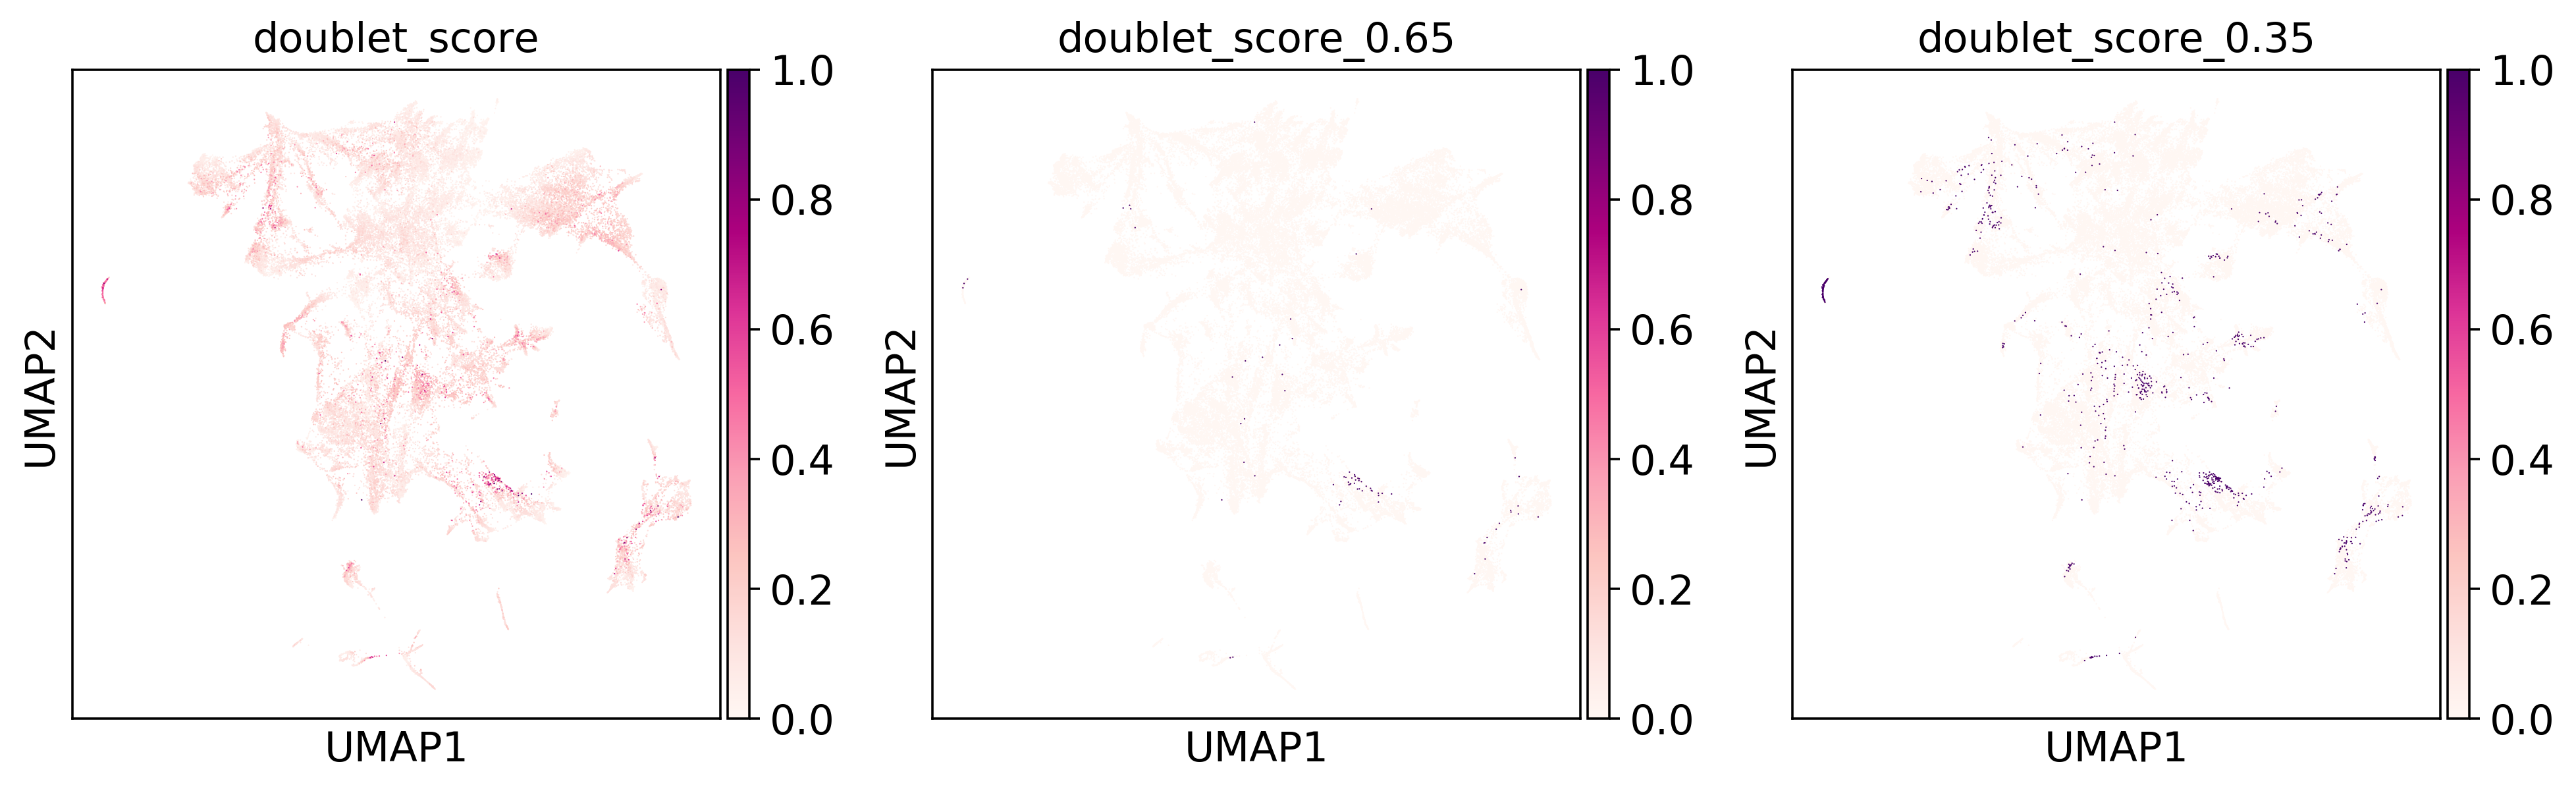

In [17]:
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
heart_hvg.obs['doublet_score_0.65'] = heart_hvg.obs['doublet_score'] > 0.65
heart_hvg.obs['doublet_score_0.35'] = heart_hvg.obs['doublet_score'] > 0.35
sc.pl.umap(heart_hvg, color = ['doublet_score', 'doublet_score_0.65', 'doublet_score_0.35'], size = 1, legend_fontsize = 6, color_map = 'RdPu')

In [18]:
print(heart_hvg.obs['doublet_score_0.35'].sum() / heart_hvg.shape[0])

0.01376601082794137


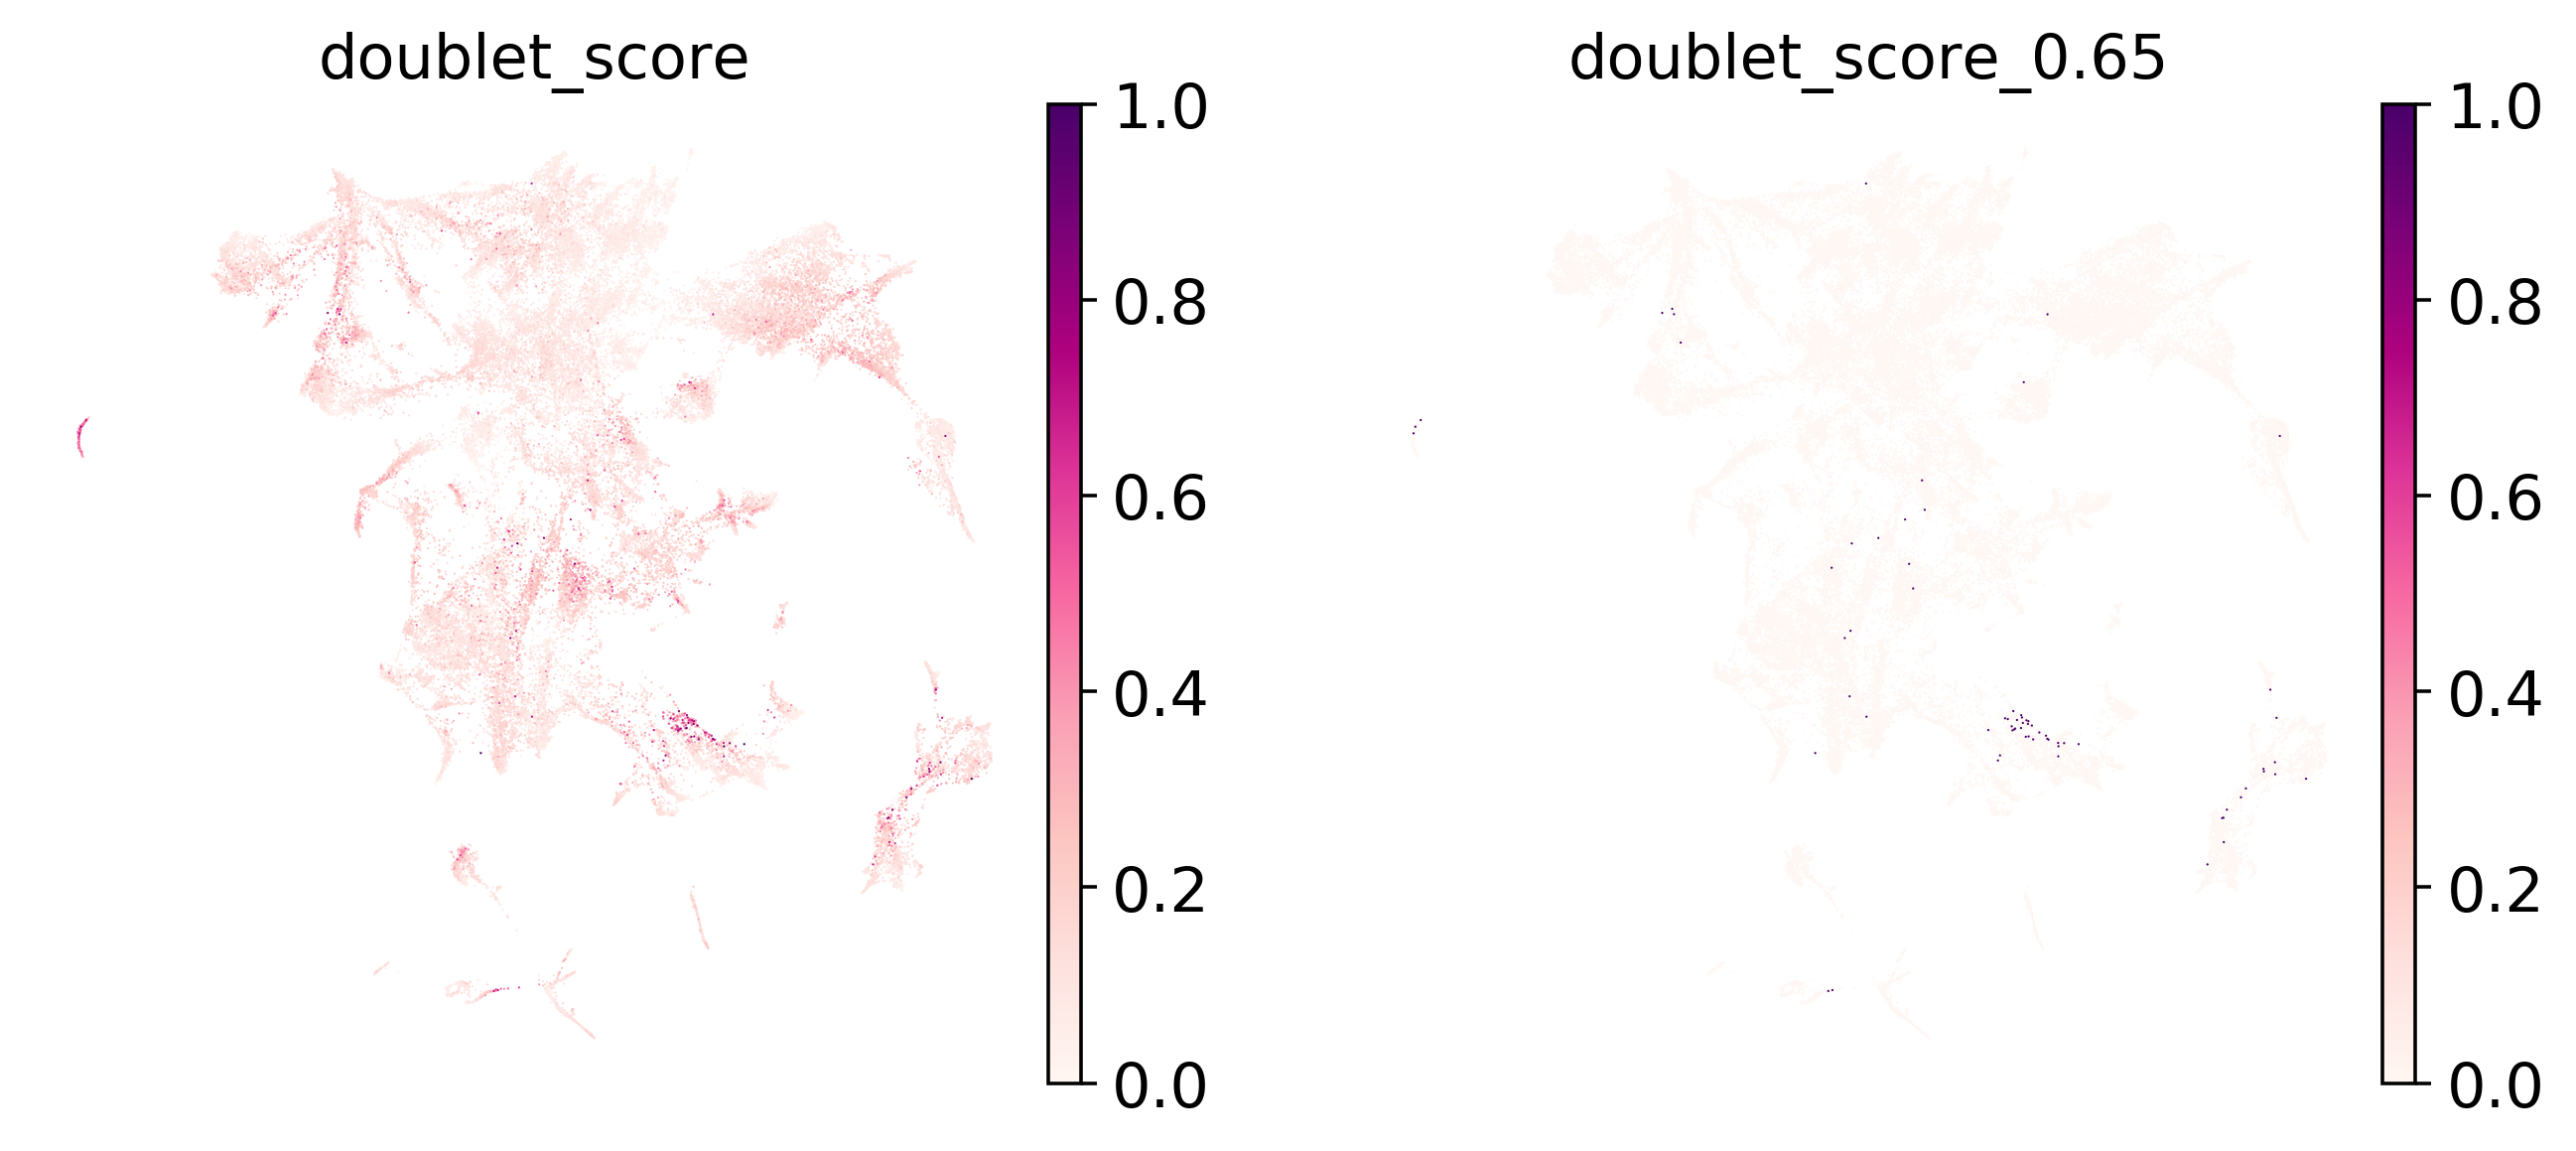

In [19]:
sc.pl.umap(heart_hvg, color = ['doublet_score','doublet_score_0.65'], size = 1, frameon = False, color_map = 'RdPu')

### Subset cells from raw data

In [20]:
data_raw = sample_object_backup[heart_hvg.obs_names]
data_raw.obs['scrublet_score'] = heart_hvg.obs['doublet_score']
data_raw

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 60584 × 33538 
    obs: 'NRP', 'age_group', 'batch', 'donor', 'gender', 'region', 'sample', 'source', 'type', 'version', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score'
    var: 'gene_ids'

In [21]:
data_raw.write_h5ad('/home/jovyan/experiments/0-generate_anndata_objects/sanger_heart_cDNA_QCed_scrublet_cellbender_ct191205.h5ad')